# Error Mitigation using Pauli Propagation

Since hardware related errors on quantum computers can not be fully error-corrected yet, many classical techniques have been developed which can account for errors.
This is known as **Quantum Error Mitigation**, and it's a classical post-processing step for calculations on NISQ-quantum computers. 

For the correction of expectation values of observables, the leading error mitigation techniques are zero-noise extrapolation (ZNE) and probabilistic error cancellation (PEC). To get an overview of common methods, the mitiq documentation is very useful (https://mitiq.readthedocs.io/en/stable/guide/guide.html, see the "What is the theory behind ...?" subriders). 

Here's an overview of what we'll cover in this notebook:

- We'll start with the most intuitive error mitigation method, Zero Noise Extrapolation (ZNE).

- Then we'll focus on an error mitigation technique called Clifford Data Regression (CDR), and an extension to  this method, Clifford Perturbation Approximation (CPA).

- Next, we can combine these 2 approaches in order to achieve even better correction. The combined technique is called variable noise CDR (CDR + ZNE = vnCDR).  We are in fact combining CPA and ZNE to Clifford Perturbation Data Regression - ZNE (CPDR - ZNE), but the main principle stays the same.

If you are interested in the background of these methods, these are the original papers
:
CDR was introduced in 2021 (http://arxiv.org/abs/2005.10189), as well as vnCDR (https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.033098). The origin of Clifford Perturbation Theory, which CPA is based on, was introduced in 2023 (http://arxiv.org/abs/2306.04797). The improved vnCDR method (CPDR-ZNE) we use was introduced in 2024 (http://arxiv.org/abs/2412.09518).

In [154]:
include("src/cpa_v2.0.jl")
global_logger(UnbufferedLogger(stdout, MainInfo)); # we can set this down to SubInfo for more verbosity

# Target circuit

The system we are interested in simulating is the transverse-field Ising model (TFIM), where the Hamiltonian is given by
$$
 H = -J\sum_{<i,j>}Z_iZ_j+h\sum_i X_i .
 $$
The first-order Trotterization of the time-dependent Schödinger equation is
$$
\begin{align}
 \ket{\psi(T)} &= \prod_{k=1}^N e^{-i\frac{T}{N}H} \ket{\psi(0)} \\
    &\approx \prod_{k=1}^N \left(\prod_{<i,j>} e^{i \frac{JT}{N}Z_i Z_j } \prod_i e^{-i \frac{hT}{N}X_i} \right) \ket{\psi(0)} \\
    &= \prod_{k=1}^N \left[ \prod_{<i,j>} R_{Z_i Z_j} \left(-\frac{2JT}{N}\right) \prod_i R_{X_i}\left(\frac{2Th}{N}\right) \right] \ket{\psi(0)} .
 \end{align}
 $$


We start by defining our target circuit within PP and visualizing the time evolution we want to correct. This visualization can only be done for small and shallow circuits, since we do not use any truncations in this step.

In [155]:
nq = 31 # number of qubits
steps = 16 # number of steps (layers)
dt = 0.05
T = steps*dt # total time, which corresponds to dt = 0.05
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  # in ordered phase: abs(h) < abs(J)
# trotter = trotter_setup(nq, steps, T, J, h); # we define a structure which holds all relevant information on our system

min_abs_coeff=1e-7
max_weight=20


# 3 loops of heavy hex
topology = [(1, 2), (1, 15), (2, 3), (3, 4), (4, 5), (5, 6), (5, 16), (6, 7), (7, 8), (8, 9), (9, 10), (9, 17),
    (10, 11), (11, 12), (12, 13), (13, 14), (13, 18), (15, 19), (16, 23), (17, 27), (18, 31), (19, 20),
    (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28),
    (28, 29), (29, 30), (30, 31)]
observable = obs_interaction(nq, topology); # ⟨ZZ⟩

By default, the function `trotter_time_evolution` has no truncations activated (`min_abs_coeff = 0.0, max_weight = Inf`). By setting `record=true`, we calculate the expectation value after each layer (rather than only for the last step).

In [156]:
layer = tfitrottercircuit(nq,1,topology=topology)
thetas = define_thetas(layer, J, h, dt)
exact_expval_target = trotter_time_evolution(nq, steps, topology, layer; observable=observable, special_thetas=thetas, noise_kind="none", min_abs_coeff=min_abs_coeff, max_weight=max_weight);

Now, we compute the corresponding noisy evolution. We can use `noise_kind = "gate_ising"`, which adds a layer of depolarizing and dephasing noise after each layer of the ansatz with a default strength of `depol_strength=0.01`, `dephase_strength=0.01`.

In [157]:
noisy_expval_target = trotter_time_evolution(nq, steps, topology, layer; observable=observable, special_thetas=thetas, noise_kind="both", min_abs_coeff=min_abs_coeff, max_weight=max_weight, depol_strength=0.02, dephase_strength=0.02);

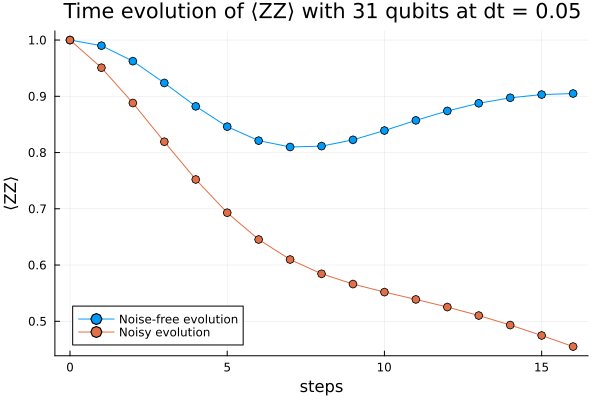

In [158]:
plot(0:steps, exact_expval_target, xlabel="steps", label="Noise-free evolution", marker=:o)
plot!(0:steps, noisy_expval_target, label="Noisy evolution", marker=:o)

if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

As we can see from the plot above, the noise affects the expectation value. Instead of following the exact evolution in blue, the noise model causes the expectation value to evolve according to the orange line.

How can we recover the exact expectation value, given only the noisy data? 

# ZNE
The most intuitive error mitigation strategy is zero noise extrapolation, where one artifically scales the noise in a quantum circuit to a set of noise levels, and then extrapolates to the zero noise value.

 On a quantum computer, this can be done by inserting identity gates (mapping a gate $G$ to $\mathbb{I} G$) or with unitary folding (mapping a gate $G$ to $GG^\dagger G$). Instead of using a quantum computer for noisy data, we simulate the noisy circuits within Pauli Propagation by building a generic noise model. Here, we can directly set the noise levels to the desired values.

First, we calculate the noisy expectation values for a set of `noise_levels`. Setting `record = true` saves the time evolution of all expectation values.

In [159]:
noise_levels = [1.0,1.3,1.5,1.8,2.0,2.2]
noisy_expval_target_levels = zne_time_evolution(nq, steps, topology, layer, J, h, dt; observable=observable, noise_levels=noise_levels, noise_kind="both", min_abs_coeff=min_abs_coeff, max_weight=max_weight);

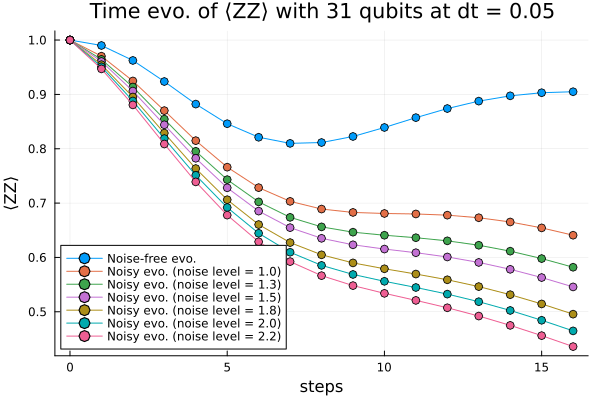

In [160]:
plot(0:steps, exact_expval_target, xlabel="steps", label="Noise-free evo.", marker=:o, legend=(0.1,0.3))
for i in 1:length(noise_levels)
    plot!(0:steps, noisy_expval_target_levels[i,:], label="Noisy evo. (noise level = $(noise_levels[i]))", marker=:o)
end

if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evo. of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq)
    plot!(ylabel="⟨Z⟩",title = "Time evo. of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

From the plot above, it is not immediately clear with which fit we will get the best correction.
Let's plot only the last step of the time evolution in semi-log scale.

In [161]:
noisy_exp_last = noisy_expval_target_levels[:,end];

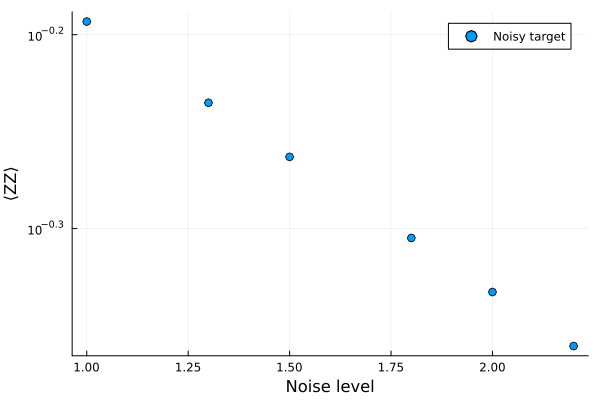

In [162]:
scatter(noise_levels, noisy_exp_last,
     xlabel="Noise level",
     ylabel="⟨ZZ⟩",
     label="Noisy target",
     marker=:o,
     legend=:topright, yaxis=:log)

We see that an exponential fit is a good choice (the points are nearly on a line on log scale).
Let's check the correction quickly only for the last value:

In [163]:
corr_zne = zne(noisy_exp_last; exact_target_exp_value=exact_expval_target[end],noise_levels =noise_levels,fit_type="exponential", use_target=true)
println("Noisy value: ", round(noisy_exp_last[1], digits = 2))
println("Corrected value: ", round(corr_zne[1], digits = 2))
println("Absolute error before correction:", round(corr_zne[3], digits = 2))
println("Absolute error after correction:" ,round(corr_zne[2], digits = 5))

Noisy value: 0.64
Corrected value: 0.88
Absolute error before correction:0.26
Absolute error after correction:0.02071


Now, we compare an exponential vs. a linear fit for ZNE.

In [164]:
corr_zne_lin, abs_after_zne_lin, abs_before_zne_lin = zne(noisy_expval_target_levels; exact_target_exp_value=exact_expval_target, noise_levels=noise_levels,fit_type="linear", use_target=true);

In [165]:
corr_zne_rich, abs_after_zne_rich, abs_before_zne_rich = zne(noisy_expval_target_levels; exact_target_exp_value=exact_expval_target, noise_levels=noise_levels, fit_type="richardson", use_target=true);

In [166]:
corr_zne_exp, abs_after_zne_exp, abs_before_zne_exp = zne(noisy_expval_target_levels; exact_target_exp_value=exact_expval_target, noise_levels=noise_levels, fit_type="exponential", use_target=true);

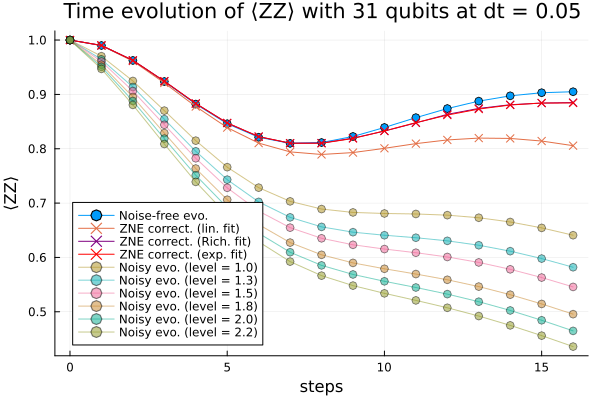

In [167]:
plot(0:steps, exact_expval_target, xlabel="steps", label="Noise-free evo.", marker=:o, legend=:bottomleft)

plot!(0:steps, corr_zne_lin, label="ZNE correct. (lin. fit)", marker=:x)
plot!(0:steps, corr_zne_rich, label="ZNE correct. (Rich. fit)", marker=:x, color ="purple")
plot!(0:steps, corr_zne_exp, label="ZNE correct. (exp. fit)", marker=:x, color ="red")

for i in 1:length(noise_levels)
    plot!(0:steps, noisy_expval_target_levels[i,:], label="Noisy evo. (level = $(noise_levels[i]))", marker=:o, alpha = 0.5)
end
if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

We can see that for this noise model, an exponential fit is a much better choice than a linear fit. Note that ZNE is usually performed with polynomial fitting (Richardson extrapolation), but for our noise model, this was not a good solution.

ZNE works well for this simple noise model, but will fail as soon as the scaled noise levels are not useful for the extrapolation anymore (in this case, the noisy values reach 0). Then one would need to exclude these points from the fit. 


In practice, it can be difficult to get enough data points with sufficiently low noise levels for a meaningful fit on a quantum computer. 

Using a classical simulation method such as PP for ZNE is also not a scalable solution unless we heavily truncate, losing accuracy in the ZNE.

# Clifford Data Regression (CDR) 
Instead of using variable-noise data (ZNE), the CDR approach performs error mitigation using variable near-Clifford circuit data.

CDR consists of the following steps:
1) Choose circuits $\ket{\phi_i}$ that are efficiently simulable and "close" to the target circuit (i.e. we replace some or all gates). This gives a set of close circuits $S_\psi  = \{\ket{\phi_i}\}$.
2) Generate a training set 
$ \mathcal{T}_\psi  = \{ X_{\phi_i}^{\text{noisy}} , X_{\phi_i}^{\text{exact}} \} $ 
by calculating the exact and noisy expectation values of all circuits in $S_\psi$.
3) Choose an ansatz to define the relation between the noisy and exact data: $ X_\psi^{\text{exact}} = f( X_\psi^{\text{noisy}},\underline{a})$. Learn the parameters $\underline{a}$ and then predict the noiseless expectation value of the target.

### 1) Training data
There are multiple ways to generate the training set for CDR. Since we are interested in the small angle regime (we want a good time resolution of the trotterized evolution), the Clifford perturbation Approximation approach (CPA) is suitable. 

Instead of only allowing for Clifford gate replacements (standard CDR), the replaced gates can be within a small interval around Clifford gates (`angle_definition`).
This allows us to closer approximate the target circuit, while leveraging the fact that PP is efficient for small angles.

We can orient ourselves on the scheme introduced in the CPA paper (`training_circuit_generation_strict_perturbation`, with keyword argument `sample_function=CPA`). We have 2 distinct angles in the trotterized circuit, the $R_{ZZ}$ angle $\theta_J = -\frac{2JT}{N}$ and the $R_X$ angle $\theta_h = \frac{2hT}{N}$. 
We replace both with a randomly sampled angle, where 
$$\theta_h \in [0,\texttt{angle\_definition}] \cup [\pi/2-\texttt{angle\_definition}, \pi/2]$$
and 
$$ \theta_J \in [-\texttt{angle\_definition},0] \cup [-\pi/2, -\pi/2 +\texttt{angle\_definition}] . $$

In the paper, the implementation is slightly different. They create a deterministic training set with 144 circuits, where:
$$ \mathcal{T} = \{(\theta_h, \theta_J) \vert \theta_h = i\pi/120, \theta_h = j\pi/120; \,\,\,i,j=0,1,2,3,4,5,54,55,56,57,58,59\}.$$
We see no conceptual difference to our `training_circuit_generation_strict_perturbation`, with keyword argument `sample_function=CPA`, if nubmer of training circuits is large enough, so we opted for this implementation.

Our implementation further allows to set `sample_function="small"`, we only choose randomly from the interval closer to 0. 

A heuristic method we derived of this approach is `training_circuit_generation_loose_perturbation`. It keeps the angle at its current value if it is already in the interval written above, and otherwise rounds to the closest boundary of the `angle_definition` interval. This means the time resolution  (or the gate angles) should not be too small, otherwise the training set consists only of the same circuits. To make sure it is not the case, we check that either $\theta_J$ or $\theta_h$ is larger than the `angle_definition`.

Remark on the original CDR approach:
In the original CDR approach, a fixed number of gates are replaced by Clifford gates. In order to guarantee similar expectation values of the training set, one needs to assume further information on the system (such as prior information of the groundstate when observing the energy). Since we do not want to use any prior information for the time evolution, we have to opt for a more expressive approach.

In [168]:
angle_definition = pi/20
list_training_thetas = training_circuit_generation_loose_perturbation(layer, J, h, dt, angle_definition; sample_function="small", num_samples=7);

### 2) Training set generation

We can use the function `training_trotter_time_evolution` to evolve all the training circuits (with and without noise). With `record = true` we save all steps of the time evolution.

In [169]:
exact_expvals_training = training_trotter_time_evolution(nq, steps, topology, layer, list_training_thetas; observable=observable, min_abs_coeff=min_abs_coeff, max_weight=max_weight);

In [170]:
noisy_expvals_training = training_trotter_time_evolution(nq, steps, topology, layer, list_training_thetas; observable=observable, noise_kind="both", min_abs_coeff=min_abs_coeff, max_weight=max_weight);

We now visualize the evolutions of some of the training circuits, to make the plot less crowded. The solid lines represent the noisy and noiseless evolutions of the target circuit . The transparent lines represent the evolution of the training circuits, with a plus marker for noiseless values and a cross marker for the noisy ones.

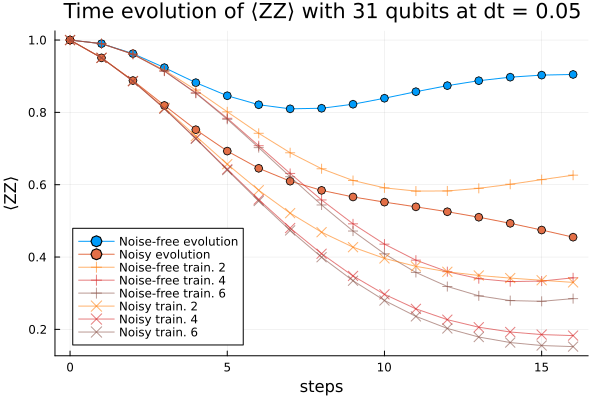

In [171]:
colors = palette(:tab10)
plot(0:steps, exact_expval_target; xlabel="steps", label="Noise-free evolution", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy evolution", marker=:o)

for i in 2:2:length(exact_expvals_training)
    exact = exact_expvals_training[i]
    plot!(0:steps, exact; label="Noise-free train. $i", c=colors[i], marker=:+, markersize = 5, alpha=0.6)
end

for i in 2:2:length(noisy_expvals_training)
    noisy = noisy_expvals_training[i]
    plot!(0:steps, noisy; label="Noisy train. $i", color=colors[i], marker=:x, markersize = 5, alpha=0.6)
end

if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

### 3) CDR
Just as in the original CDR paper, we start by correcting the noisy expecation value with a linear ansatz. The motivation is that this ansatz is the exact solution for a general quantum erasure noise channel, which takes the input state $\rho$ to
$$
  \rho \rightarrow (1-p_\text{error}) \rho  + p_\text{error}\ \rho_0 .
$$
Thus, we can perform least squares regression (which assumes Gaussian noise) to find the optimal parameters $a_1,a_2$ in the following dependency for the noiseless expectation value
$$
X_\psi^{\text{exact}} = f( X_\psi^{\text{noisy}},a )  = a_1 X_\psi^{\text{noisy}} + a_2 .
$$
The function `cdr` gives the final corrected value, and if `use_target = true`, gives the absolute error before and after the correction.

To visualize how the CDR correction performs over time, there is a second method `cdr` which calculates the correction for every time step. Note that we cannot correct noise during time evolution, since we only working with the expectation values and cannot reconstruct the corrected state from one expectation value.

Finally, we implemented weighted linear regression as a heuristic alternative, where we can define a vector of decaying weights for previous time steps that then also contribute to the fit.

We first correct only the last step of the time evolution.

In [172]:
noisy_expvals_training_last = [row[end] for row in noisy_expvals_training]
exact_expvals_training_last = [row[end] for row in exact_expvals_training]
noisy_expval_target_last = noisy_expval_target[end]
exact_expval_target_last = exact_expval_target[end]
corr_last, abs_error_after_cdr_last, abs_error_before_cdr_last = cdr(
    noisy_expvals_training_last,
    exact_expvals_training_last,
    noisy_expval_target_last;
    exact_target_exp_value=exact_expval_target_last,
    use_target=true
)
println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 2))
println("Corrected value at the last timestep: ", round(corr_last, digits = 2))
println("Absolute error before correction: ", round(abs_error_before_cdr_last,digits =2))
println("Absolute error after correction: ", round(abs_error_after_cdr_last, digits = 4))

Noisy value at the last timestep: 0.45
Corrected value at the last timestep: 0.87
Absolute error before correction: 0.45
Absolute error after correction: 0.0354


We now do CDR for all time steps to visualize the evolution of the correction. As before for ZNE, we are only considering the current time step for our correction. It is important to note that we can't correct continously, because we can't reconstruct the state from the corrected expectation value.

In [173]:
corr_cdr, abs_after_cdr, abs_before_cdr = cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target; exact_target_exp_value=exact_expval_target, use_target=true
);

Another possibility is using weighted linear regression, where we take into account some or all previous time steps.

In [174]:
#CDR with decaying weights
decay_weights_partial_mem = [
    [τ == t ? 1.0 : (τ == t-1 ? 0.5 : 0.0) for τ in 1:t]
    for t in 1:length(noisy_expvals_training[1])
]
corr_weight_partial_mem, abs_after_weight_partial_mem, abs_before_weight_partial_mem= cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target, decay_weights_partial_mem; exact_target_exp_value=exact_expval_target, use_target=true
);

decay_weights_linear = [[τ / t for τ in 1:t] for t in 1:length(noisy_expvals_training[1])]
corr_weight_lin, abs_after_weight_lin, abs_before_weight_lin = cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target, decay_weights_linear; exact_target_exp_value=exact_expval_target, use_target=true
);

We can now compare the variations of the CDR method with each other.

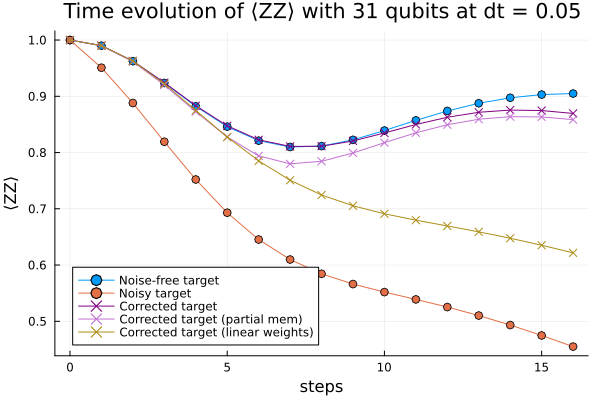

In [175]:
#plot time evolution
plot(0:steps, exact_expval_target; xlabel="steps", label="Noise-free target", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy target", marker=:o)
plot!(0:steps, corr_cdr; label="Corrected target", marker=:x, color = "purple")
plot!(0:steps, corr_weight_partial_mem; label="Corrected target (partial mem)", marker=:x)
plot!(0:steps, corr_weight_lin; label="Corrected target (linear weights)", marker=:x)


if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

For this system, sticking to the standard linear regression is the best choice. We did not set a truncation order here, because the system is small enough. This method can nonetheless scale well for bigger simulations such as the "utility" experiment with 127 qubits, by using truncations. 

# vnCDR
The CDR and ZNE method can be combined to improve the error correction.
For each circuit from the training set, one calculates the expectation value at multiple noise levels, as well as the corresponding noiseless expectation value. Note here that vnCDR works with the varied noise levels of the training circuits, while ZNE works with the varied noise levels of the target circuit as shown above.

More precisely, we will be implementing CPDR-ZNE as described in the CPA paper. This is based on the same idea as vnCDR, but allows for a small angle perturbation from Cliffords in the training circuit generation. Additionally, it uses a Ridge Regression to reduce overfitting.

In [176]:
exact_expvals_training_levels = training_trotter_time_evolution(
    nq, steps, topology, layer, 
    list_training_thetas;
    observable = observable,
    noise_kind = "none",
    min_abs_coeff=min_abs_coeff,
    max_weight=max_weight
);

In [177]:
noisy_expvals_training_levels = vnCDR_training_trotter_time_evolution(nq, steps, topology, layer, list_training_thetas; observable = observable, noise_kind="both",noise_levels = noise_levels, min_abs_coeff=min_abs_coeff, max_weight=max_weight);

In [178]:
noisy_expvals_training_levels_end = noisy_expvals_training_levels[:,:,end];

In [179]:
exact_expvals_training_end = [row[end] for row in exact_expvals_training];

We can use vnCDR for the last step of the time evolution:

In [180]:
# "exponential" fit in the noise levels (fit_type="exponential")
pred_exp, abs_after_exp, abs_before_exp = vnCDR(
    noisy_expvals_training_levels_end,
    exact_expvals_training_end,
    noisy_exp_last;
    exact_target_exp_value=exact_expval_target[end],
    use_target=true, fit_type="exponential", fit_intercept=false
)

println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 2))
println("Corrected value at the last timestep: ", round(pred_exp[1], digits = 2))
println("Absolute error before correction: ", round(abs_before_exp[1], digits = 2))
println("Absolute error after correction: ", round(abs_after_exp[1], digits = 8))

Noisy value at the last timestep: 0.45
Corrected value at the last timestep: 0.91
Absolute error before correction: 0.47
Absolute error after correction: 0.00232493


In [181]:
#fitting to a hyperplane (fit_type="linear" by default)
pred, abs_after, abs_before = vnCDR(
    noisy_expvals_training_levels_end,
    exact_expvals_training_end,
    noisy_exp_last; exact_target_exp_value = exact_expval_target[end], use_target=true, lambda = 0.0
)
println("Noisy value at the last timestep: ", round(noisy_expval_target_last, digits = 3))
println("Corrected value at the last timestep: ", round(pred[1], digits = 3))
println("Absolute error before correction: ", round(abs_before[1], digits = 3))
println("Absolute error after correction: ", round(abs_after[1], digits = 12))

Noisy value at the last timestep: 0.455
Corrected value at the last timestep: 0.902
Absolute error before correction: 0.469
Absolute error after correction: 0.003205055685


We can also correct the values for each time step.

In [182]:
corr_vnCDR_lin, abs_after_vnCDR_lin, abs_before_vnCDR_lin = vnCDR(
    noisy_expvals_training_levels,
    exact_expvals_training,
    noisy_expval_target_levels; exact_target_exp_value=exact_expval_target, use_target=true
);

In [183]:
corr_vnCDR_exp, abs_after_vnCDR_exp, abs_before_vnCDR_exp = vnCDR(
    noisy_expvals_training_levels,
    exact_expvals_training,
    noisy_expval_target_levels; exact_target_exp_value=exact_expval_target, use_target=true, fit_type="exponential"  
);

### Comparison plot of all methods
We now plot the final results from vnCDR and compare these to the results from its components, ZNE and CDR.

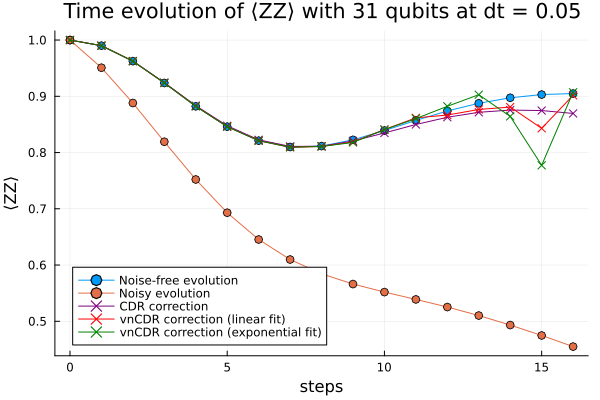

In [184]:
plot(0:steps, exact_expval_target; xlabel="steps", label="Noise-free evolution", marker=:o, legend=:bottomleft)
plot!(0:steps, noisy_expval_target; label="Noisy evolution", marker=:o)
plot!(0:steps, corr_cdr; label="CDR correction", marker=:x, color = "purple")
plot!(0:steps, corr_vnCDR_lin; label="vnCDR correction (linear fit)", marker=:x, color = "red")
plot!(0:steps, corr_vnCDR_exp; label="vnCDR correction (exponential fit)", marker=:x, color = "green")

if observable == obs_interaction(nq, topology)
    plot!(ylabel="⟨ZZ⟩", title ="Time evolution of ⟨ZZ⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
elseif observable == obs_magnetization(nq)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(nq) qubits at dt = $(round((T/steps), digits = 2))")
end

All methods seem to mitigate the errors well, so let's look at the absolute error in log scale.

We can't start from the initial state at start = 1 (Julia indexes from 1), because we have an absolute error of 0 which can't be plotted in log-scale. Since the correction is very accurate for the first few steps, we have to start at the second time step (start = 3) to avoid 0 values. 

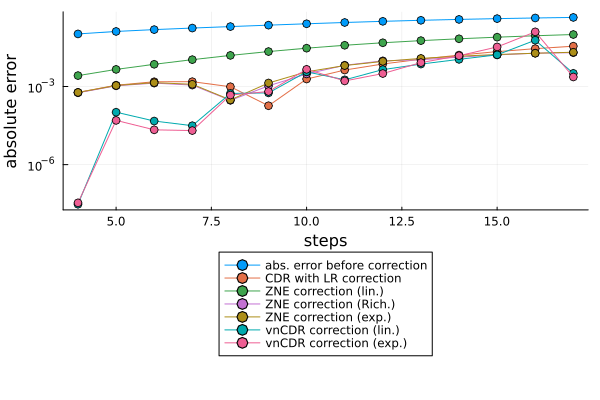

In [185]:
start = 4

plot(start:steps+1, abs_before_cdr[start:end], xlabel="steps", ylabel = "absolute error", label="abs. error before correction", marker=:o, legend=:outerbottom, yscale=:log10)


# plain CDR and weighted CDR
plot!(start:steps+1, abs_after_cdr[start:end], label="CDR with LR correction", marker=:o)

# plain ZNE
plot!(start:steps+1, abs_after_zne_lin[start:end], label="ZNE correction (lin.)", marker=:o)
plot!(start:steps+1, abs_after_zne_rich[start:end], label="ZNE correction (Rich.)", marker=:o)
plot!(start:steps+1, abs_after_zne_exp[start:end], label="ZNE correction (exp.)", marker=:o)

# vnCDR
plot!(start:steps+1, abs_after_vnCDR_lin[start:end], label="vnCDR correction (lin.)", marker=:o, yscale=:log10)
plot!(start:steps+1, abs_after_vnCDR_exp[start:end], label="vnCDR correction (exp.)", marker=:o, yscale=:log10)

We can see here that even though ZNE performs better with an exponential fit than with a linear fit, linear vnCDR (which fits a hyperplane) outperforms the vnCDR that fits to exponential noise. 

Another important thing to note is that the computational effort for vnCDR is much lower than for ZNE in our code once we use truncations. For ZNE, we need to compute the expectation value of the noise model applied to the non near-Clifford target circuit for various noise levels. 

In vnCDR, we also compute these noise levels for each target circuit (so more expecation values to calculate in total), but crucially, performing classical simulations of the near-Clifford (or CPA) circuits is faster if we activate the truncation schemes.

So for larger systems using ZNE becomes inefficient, while vnCDR has a good efficiency-accuracy tradeoff.